In [ ]:
# Install imbalanced-learn for handling imbalanced datasets
!pip install imbalanced-learn
!pip install ipywidgets

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Balancing the dataset
from imblearn.over_sampling import SMOTE

# PyTorch for neural network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Widgets for interactive inputs
import ipywidgets as widgets
from IPython.display import display

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.2 MB/s eta 0:00:00


## 2. Load and Explore the Dataset
We load the dataset and print basic info.




In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Setting file paths
train_data_path = '/content/drive/My Drive/dataEaex3CNN/fashion-mnist_train.csv'
test_data_path = '/content/drive/My Drive/dataEaex3CNN/fashion-mnist_test.csv'

# Local copy (optional)
!cp "/content/drive/My Drive/dataEaex3CNN/fashion-mnist_train.csv" /content/
!cp "/content/drive/My Drive/dataEaex3CNN/fashion-mnist_test.csv" /content/
train_data_path = '/content/fashion-mnist_train.csv'
test_data_path = '/content/fashion-mnist_test.csv'


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

#data peeks
print(train_data.head())
print(test_data.head())

print(train_data.info())
print(test_data.info())

print(train_data.describe())
print(test_data.describe())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

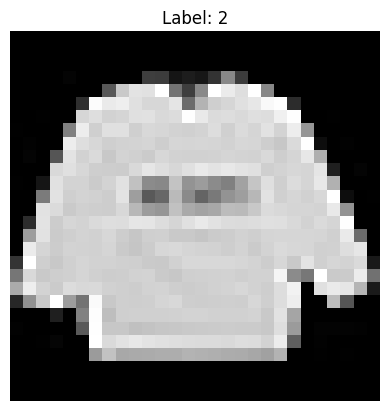

In [ ]:
#example of the data
index = 0
image = train_data.iloc[index, 1:].values.reshape(28, 28) # 28x28 pixels
label = train_data.iloc[index, 0]

plt.imshow(image, cmap="gray")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

## Custom Dataset

In [ ]:
from PIL import Image

class FashionMNISTDataset(Dataset):
  def __init__(self, images,labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img = self.images[index].reshape(28, 28)
    label = self.labels[index]

    img = (img *255).astype(np.uint8)
    img_pil = Image.fromarray(img)
    img_pil_rgb = img_pil.convert('RGB')

    if self.transform:
      img_tensor = self.transform(img_pil_rgb)
    else:
      img_np = np.array(img_pil_rgb).transpose((2, 0, 1))/255.
      img_tensor = torch.from_numpy(img_np).float()

    return img_tensor, label

In [ ]:
import torchvision.transforms as T
from torch.utils.data import DataLoader

#transforms to the train set to make a better fit to wider cases.
train_transform = T.Compose([
    # Resize image to 224x224.
    T.Resize((224, 224)),
    #random horizontal flip in 50% of cases
    T.RandomHorizontalFlip(p=0.5),
    #random rotation up to 10 degrees
    T.RandomRotation(degrees=10),
    #random color changes
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # Convert PIL to tensor.
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_resnet = T.Compose([
    # Resize image to 224x224.
    T.Resize((224, 224)),
    # Convert PIL to tensor.
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # ImageNet mean/std normalization.
])


#  take the data img and labels
train_images = train_data.iloc[:, 1:].values  # all columns but the first
train_labels = train_data.iloc[:, 0].values  # first col

 #חלוקה של הTRAIN ל80\20 עם VAL TRAIN
num_samples = train_images.shape[0]
indices = np.arange(num_samples)
np.random.shuffle(indices)
train_size = int(0.8 * num_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

#create array to train and validation
train_images_shuffled = train_images[train_indices]
train_labels_shuffled = train_labels[train_indices]
val_images_shuffled = train_images[val_indices]
val_labels_shuffled = train_labels[val_indices]

#create datasets
# Training dataset with ResNet transforms.
train_dataset = FashionMNISTDataset(train_images_shuffled, train_labels_shuffled, transform=train_transform)
# Validation dataset with ResNet transforms.
val_dataset = FashionMNISTDataset(val_images_shuffled, val_labels_shuffled, transform=eval_resnet)

In [ ]:
#test for the final results- we are not going to use for now.
test_images = test_data.iloc[:, 1:].values
test_labels = test_data.iloc[:, 0].values
# test dataset with ResNet transforms.
test_dataset = FashionMNISTDataset(test_images, test_labels, transform=eval_resnet)

In [ ]:
#data loaders
batch_size = 32
# Training DataLoader, batch 32, shuffle.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Validation DataLoader, batch 32, shuffle.
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# Test DataLoader, batch 32, shuffle.
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#tiny test
for images, labels in train_loader:
    print(f"Batch size: {images.size()}, Labels: {labels.size()}")
    break

Batch size: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])


## Visualizing Sample Images

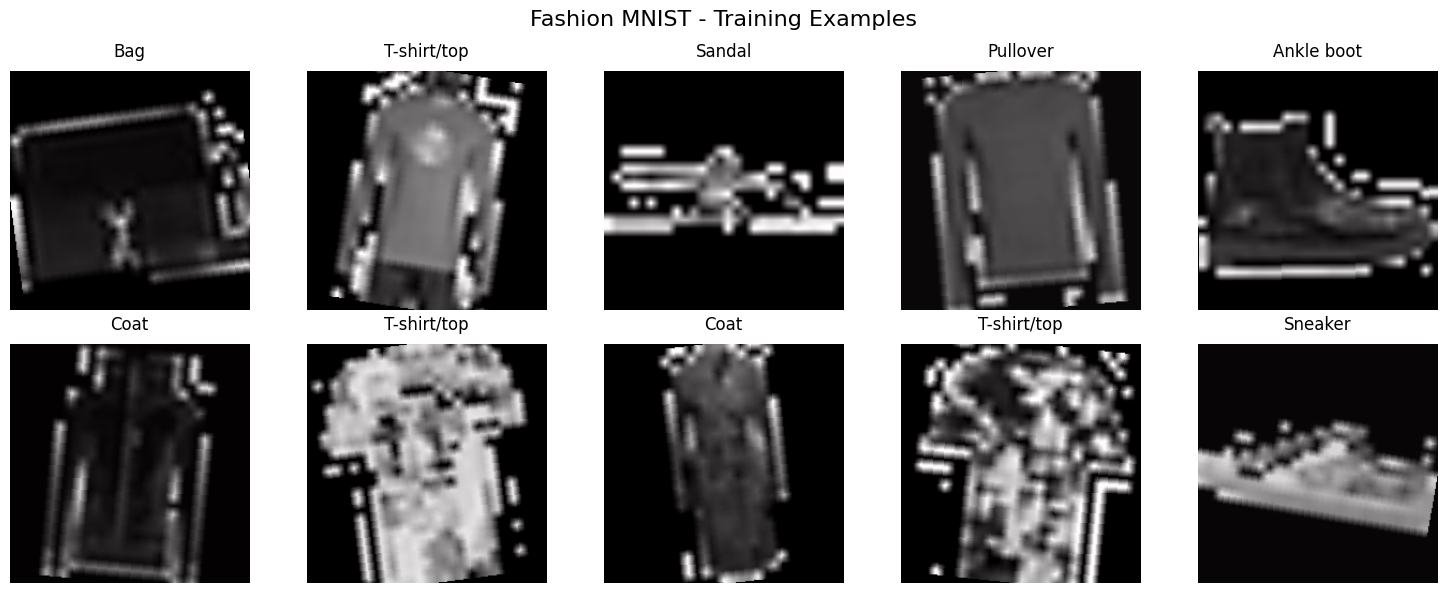

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np

#names of all parts of cloasing thats in Fashion MNIST
fashion_mnist_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

data_iter = iter(train_loader)
images, labels = next(data_iter)

#inverse normalization
inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.229, -0.406/0.229],
    std=[1/0.229, 1/0.224, 1/0.225]
)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Fashion MNIST - Training Examples', fontsize=16)

for i in range(10):
    ax = axs[i//5, i%5]

    # img accept and de normalize
    img = inv_normalize(images[i]).cpu().detach().numpy()
    img = np.transpose(img, (1, 2, 0))

    # limit values between 0 to 1 to not make artifacts.
    img = np.clip(img, 0, 1)

    # accepte the label
    label_idx = labels[i].item()
    label_name = fashion_mnist_labels[label_idx]

    # show img
    ax.imshow(img)
    ax.set_title(label_name, pad=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

#2. Model create

In [ ]:
import torch.nn as nn
# nn for network layers.
import torch.optim as optim
# optim for optimization.
import torchvision.models as models
# models to load pretrained ResNet.
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns

#hyperparameters
INITIAL_EPOCHS = 5
FINE_TUNING_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.001
FINE_TUNING_LR = 0.0001


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Device selection.
model = models.resnet18(pretrained=True)
# Load pretrained ResNet18.

# Freeze all parameters.
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
# Get the number of input features.
num_classes = 10
model.fc = nn.Linear(num_ftrs, num_classes)
# Replace the last fully connected layer with a new one.
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.3MB/s]


##Train

Starting initial training (frozen layers)...
Epoch 1/5:
Train Loss: 0.8462, Train Acc: 71.21%
Val Loss: 0.7036, Val Acc: 75.93%
Epoch 2/5:
Train Loss: 0.6593, Train Acc: 76.86%
Val Loss: 0.6544, Val Acc: 76.50%
Epoch 3/5:
Train Loss: 0.6236, Train Acc: 77.97%
Val Loss: 0.6456, Val Acc: 77.08%
Epoch 4/5:
Train Loss: 0.6152, Train Acc: 78.32%
Val Loss: 0.6362, Val Acc: 78.01%
Epoch 5/5:
Train Loss: 0.6037, Train Acc: 78.79%
Val Loss: 0.6263, Val Acc: 77.77%


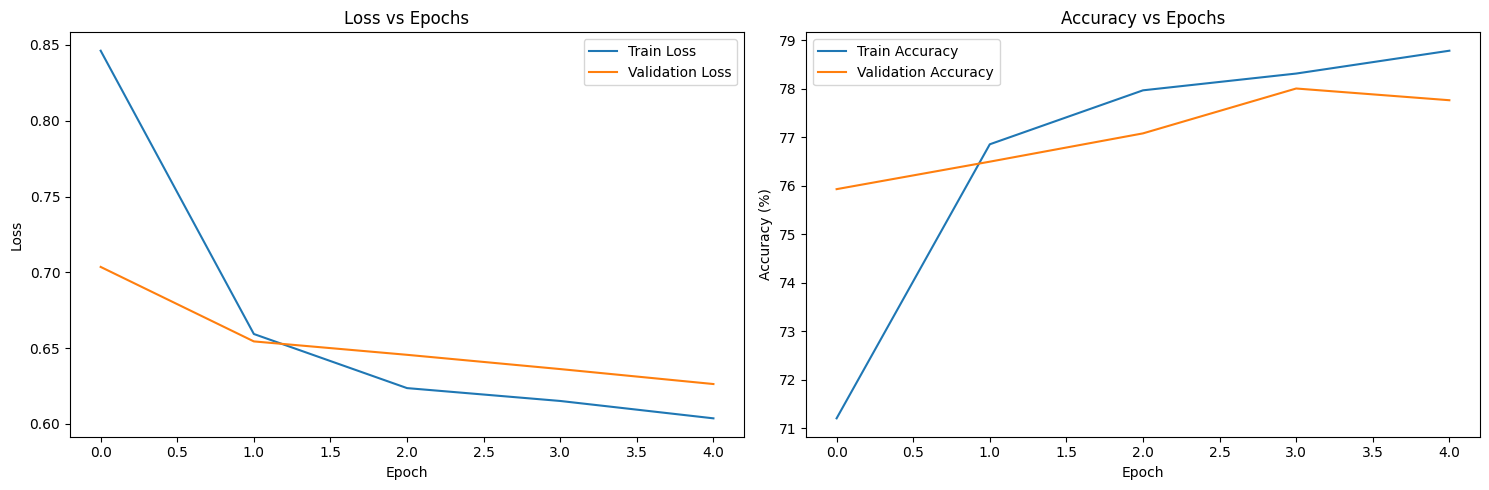


Starting fine-tuning...
Epoch 1/5:
Train Loss: 0.3616, Train Acc: 87.20%
Val Loss: 0.2326, Val Acc: 91.53%
Epoch 2/5:
Train Loss: 0.2307, Train Acc: 91.71%
Val Loss: 0.2109, Val Acc: 92.43%
Epoch 3/5:
Train Loss: 0.1893, Train Acc: 93.21%
Val Loss: 0.2025, Val Acc: 92.47%
Epoch 4/5:
Train Loss: 0.1694, Train Acc: 93.91%
Val Loss: 0.1836, Val Acc: 93.27%
Epoch 5/5:
Train Loss: 0.1475, Train Acc: 94.49%
Val Loss: 0.1880, Val Acc: 93.43%


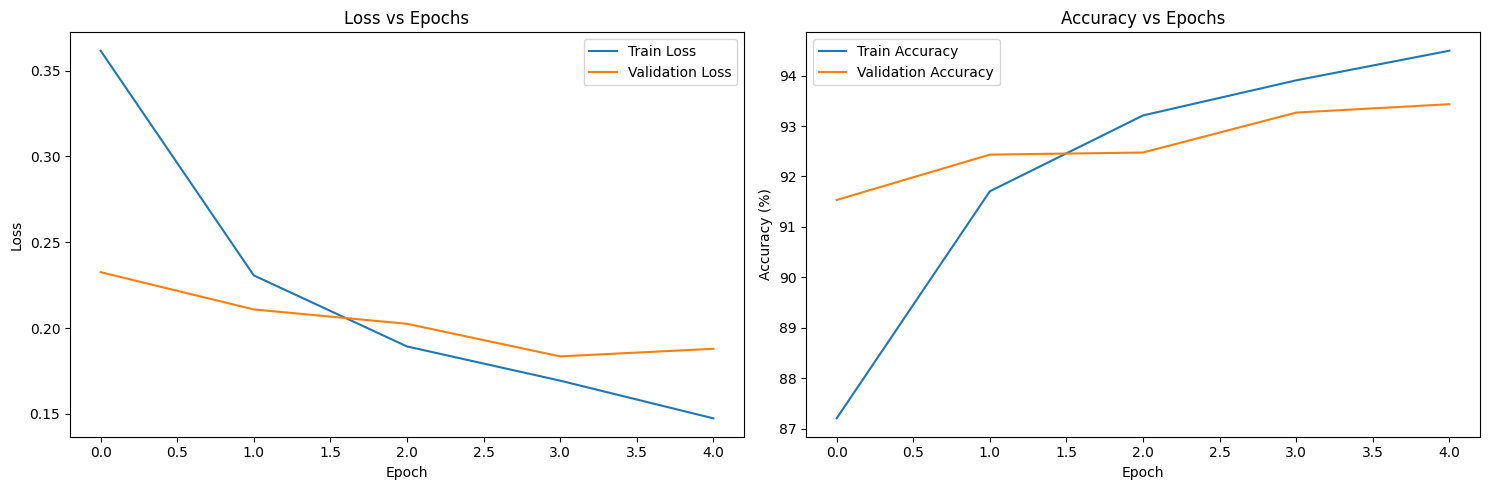


Evaluating final model...

Final Test Results:
Test Loss: 0.1807
Test Accuracy: 0.9385
Test Precision: 0.9394
Test Recall: 0.9385
Test F1 Score: 0.9387


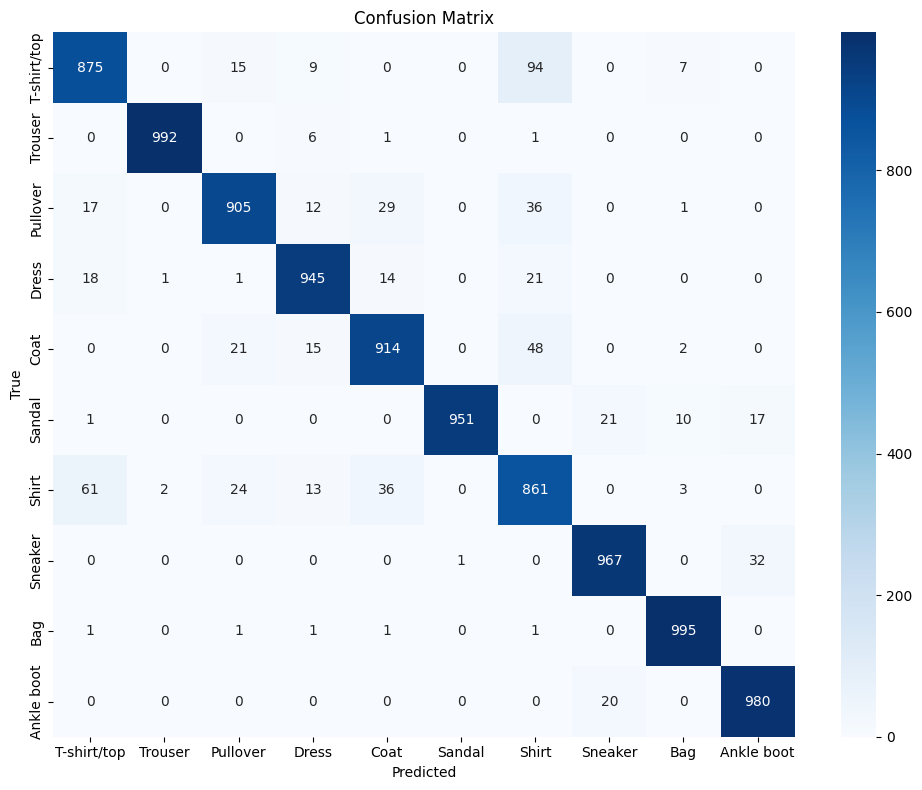

In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    return train_losses, val_losses, train_accs, val_accs

# Function to evaluate model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return {
        'loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_preds,
        'true_labels': all_labels
    }

# Function to plot training history
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Loss vs Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracies
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_title('Accuracy vs Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Main training process
print("Starting initial training (frozen layers)...")
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, INITIAL_EPOCHS, device
)

# Plot initial training results
plot_training_history(train_losses, val_losses, train_accs, val_accs)

# Fine tuning
print("\nStarting fine-tuning...")
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# New optimizer for all parameters with lower learning rate
optimizer = optim.Adam(model.parameters(), lr=FINE_TUNING_LR)

# Train with unfrozen layers
fine_tune_train_losses, fine_tune_val_losses, fine_tune_train_accs, fine_tune_val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, FINE_TUNING_EPOCHS, device
)

# Plot fine-tuning results
plot_training_history(fine_tune_train_losses, fine_tune_val_losses,
                     fine_tune_train_accs, fine_tune_val_accs)

# Final evaluation
print("\nEvaluating final model...")
results = evaluate_model(model, test_loader, criterion, device)

print(f"\nFinal Test Results:")
print(f"Test Loss: {results['loss']:.4f}")
print(f"Test Accuracy: {results['accuracy']:.4f}")
print(f"Test Precision: {results['precision']:.4f}")
print(f"Test Recall: {results['recall']:.4f}")
print(f"Test F1 Score: {results['f1']:.4f}")

# Plot confusion matrix
plot_confusion_matrix(results['true_labels'], results['predictions'],
                     list(fashion_mnist_labels.values()))

##5 השוואה בין מודל CNN לבין מודל RESNET
מודל "רזנט" שמאומן מראש , קצב הירידה "הפסד" היה מאוד מהיר בהשוואה סיאנאן  שזה נובע מהעובדה שהוא למד כבר תכונות בסיסיות כלליות ולכן דרש פחות אפוקים כדי להגיע לביצועים גבוהים.

מודל "רזנט" הגיע לביצועים גבוהים יותר של 94.49% באימון ו93.85% במבחן, לעומת 93.15% של סיאנאן בתרגיל 4.

מודל "רזנט" יציב יותר עשה פער בין ביצועי האימון לאימות היו נמצוכים דבר שמעיד כל מניעת אוברפיטינג טובה.

אילן מצבים למידה מעבירה עדיפה על אימון מאפס?


*   כאשר כמות הנתונים מוגבלת למידה מעבירה מנצלת ידע כללי שנלמד על מערכי נתונים גדולים יותר כך שהיא יעלה כאשר יש דאטה קטן יחסית.
*   חוסכת בזמן חישוב: בגלל שהמודל אומן על תכונות בסיסיות תהליך האימון קצר יותר ופחות תובעני מבחינת משאבים.
*   משפר ביצועים במהירות: במקום להתחיל מאפס, המודל משיג ביצועים גבוהים מוקדם יותר בתהליך האימון.


##תיעוד ממצאים עיקריים:


*   דיוק גבוה יותר: הידע הכללי של "רזנט" נתן יתרון משמעותי במערך הנתונים
*   פיין- טיונינג: שחרור שכבות ההקפאה שאפשר למודל להתאים את עצמו בצורה מדוייקת יותר לנתונים הספציפיים, מה שהוביל לעלייה נוספת בביצועים(מ78% ל94.49%)

## אתגרים שהתגלו במהלך העבודה


*   עומס חישובי: מודל "רזנט" דורש משאבים חישוביים גבוהים יותר בהשוואה ל"סיאנאן" מותאם אישית במיוחד במהלך הפיין - טיונינג
*   אוברפיטינג פוטנציאלי: בשלבים מוקדמים של הפיין-טיונינג היה סיכון לאימון יתר, אבל שימוש בדרופאאוט עזר לשלוט בזה.(זה שהשכבות הראשונות מוקפאות זה גם חלק מזה)


##השוואות מרכזיות בין המודלים



| **מאפיין**            | **מודל CNN מותאם אישית** | **מודל ResNet (למידה מעבירה)** |
|------------------------|---------------------------|-----------------------------------|
| **דיוק באימון**       | 89.17%                   | 94.49%                           |
| **דיוק באימות**       | 93.15%                   | 93.43%                           |
| **דיוק במבחן**        | 93.15%                   | 93.85%                           |
| **הפסד (Loss)**       | נמוך אך עולה לאחר זמן   | נמוך ומתכנס במהירות             |


###מסקנות
היתרונות של למידה מעבירה באמצעות מודל "רזנט" הוכחה ככלי חזק שכבר מאומן על מערכי נתונים גדולים ומגוונים, מה שאיפשר זיהוי יעיל שלש תכונות כלליות בתמונות, עם זאת למרות שהמודל הגיע להתכנסות מהירה יותר מבחינת הדיוק לאחר שלב הפיינטיוניג, האימון הראשוני של הרזנט היה איטי יותר בהשוואה לאימון מודל ה"סיאנאן". יתרון נוסף של למידה מעבירה ניכר בכמות המידע: כאשר מערך הנתונים מוגבל מודל "רזנט" מציע פתרון יעיל בהרבה בהשוואה לאימון מאפס.

בעוד שמודל ה"סיאנאן" הצליח להגיע לדיוק גבוה בזכות המבנה המותאם שלו, דרשו לו יותר אפוקים על מנת להגיע להתכנסות, וזמן ההתכנסות היה איטי יותר באופן יחסי. "רזנט"  הציג שיפור משמעותי לאחר הפיינטיונינג, שבו השכבות הפנימיות שוחררו.

למידה מעבירה מציעה יתרונות משמעותיים בזיהוי תכונות כלליות של התמונות ובהתכנסות מהירה לאחר הפיינטיונינג, והיא אפקטיבית במיוחד כאשר כמות הנתונים מוגבלת. עם זאת, עבור פרוייקטים שבהם זמן האימון הוא קריטי, מודל מותאם אישית עשוי להיות בחירה עדיפה בשל זמן אימון קצר יותר.

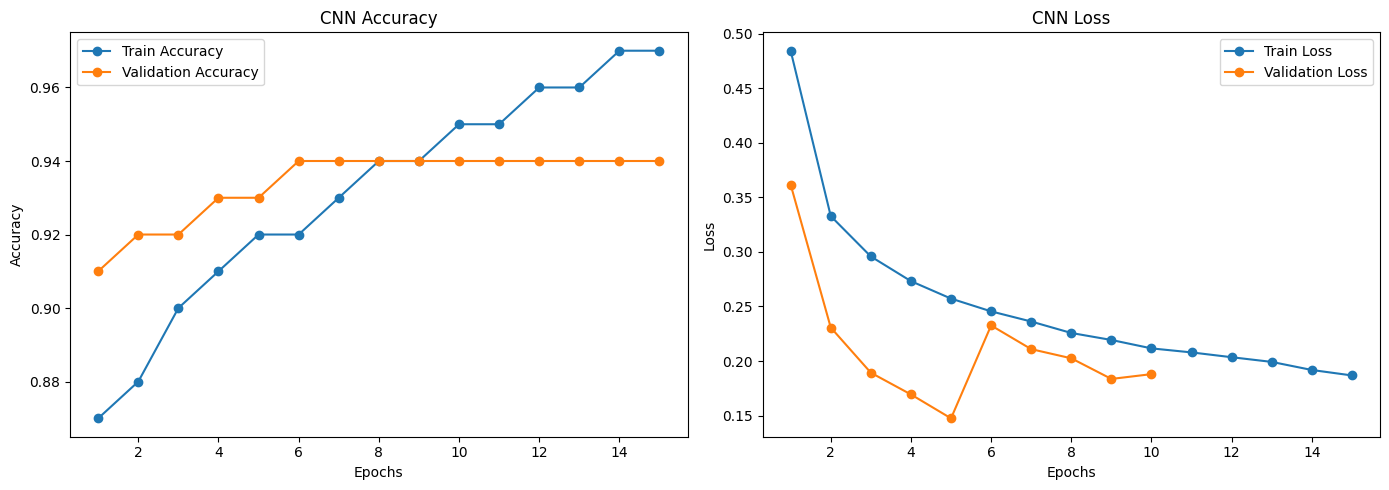

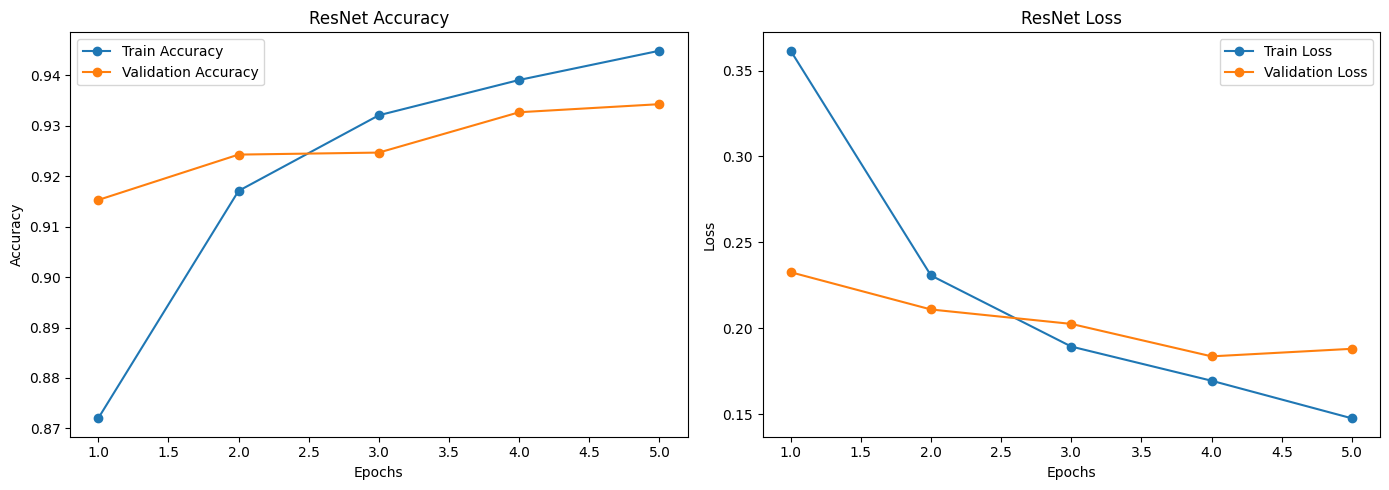

In [ ]:
import matplotlib.pyplot as plt

#  CNN
epochs_cnn = range(1, 16)
train_acc_cnn = [0.87, 0.88, 0.90, 0.91, 0.92, 0.92, 0.93, 0.94, 0.94, 0.95, 0.95, 0.96, 0.96, 0.97, 0.97]
val_acc_cnn = [0.91, 0.92, 0.92, 0.93, 0.93, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94]
train_loss_cnn = [0.4843, 0.3328, 0.2958, 0.2732, 0.2572, 0.2455, 0.2362, 0.2257, 0.2193, 0.2116, 0.2079, 0.2035, 0.1992, 0.1918, 0.1868]
val_loss_cnn = [0.3616, 0.2307, 0.1893, 0.1694, 0.1475, 0.2326, 0.2109, 0.2025, 0.1836, 0.1880]

#  ResNet
epochs_resnet = range(1, 6)
train_acc_resnet = [0.8720, 0.9171, 0.9321, 0.9391, 0.9449]
val_acc_resnet = [0.9153, 0.9243, 0.9247, 0.9327, 0.9343]
train_loss_resnet = [0.3616, 0.2307, 0.1893, 0.1694, 0.1475]
val_loss_resnet = [0.2326, 0.2109, 0.2025, 0.1836, 0.1880]

# graphs for CNN
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_cnn, train_acc_cnn, label='Train Accuracy', marker='o')
plt.plot(epochs_cnn, val_acc_cnn, label='Validation Accuracy', marker='o')
plt.title('CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_cnn[:len(train_loss_cnn)], train_loss_cnn, label='Train Loss', marker='o')
plt.plot(epochs_cnn[:len(val_loss_cnn)], val_loss_cnn, label='Validation Loss', marker='o')
plt.title('CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# graphs for ResNet
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_resnet, train_acc_resnet, label='Train Accuracy', marker='o')
plt.plot(epochs_resnet, val_acc_resnet, label='Validation Accuracy', marker='o')
plt.title('ResNet Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_resnet, train_loss_resnet, label='Train Loss', marker='o')
plt.plot(epochs_resnet, val_loss_resnet, label='Validation Loss', marker='o')
plt.title('ResNet Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

##5 Comparison between CNN and RESNET models
The pre-trained Resnet model had a very fast "loss" rate compared to CyanN, which is due to the fact that it has already learned general basic features and therefore required fewer epochs to achieve high performance.

The Resnet model achieved higher performance of 94.49% in training and 93.85% in testing, compared to 93.15% for CyanN in Exercise 4.

The more stable Resnet model made a gap between the training and validation performances narrow, which indicates good overfitting prevention.

Is transfer learning better than training from scratch?

* When the amount of data is limited, transfer learning exploits general knowledge learned on larger datasets so that it will outperform when there is relatively little data.
* Saves computational time: Because the model is trained on basic features, the training process is shorter and less demanding in terms of resources.
* Improves performance quickly: Instead of starting from scratch, the model achieves high performance earlier in the training process.

##Documentation of key findings:

* Higher accuracy: Resent's general knowledge gave a significant advantage in the dataset
* Fine-tuning: Releasing the freeze layers allowed the model to adapt more precisely to the specific data, leading to a further increase in performance (from 78% to 94.49%)

## Challenges discovered during the work

* Computational load: The Resent model requires higher computational resources compared to the specially customized Cyanan during fine-tuning
* Potential overfitting: In the early stages of fine-tuning, there was a risk of overfitting, but using dropout helped control this. (The fact that the first layers are frozen is also part of this)

##Key comparisons between the models

| **Feature** | **Custom CNN Model** | **ResNet Model (Transfer Learning)** |
|-------------------------|--------------------------|-----------------------------------|
| **Training Accuracy** | 89.17% | 94.49% |
| **Validation Accuracy** | 93.15% | 93.43% |
| **Test Accuracy** | 93.15% | 93.85% |
| **Loss** | Low but increases over time | Low and converges quickly |

###Conclusions
The advantages of transfer learning using the Resent model have been proven to be a powerful tool already trained on large and diverse datasets, which allowed for the efficient identification of three general features in images. However, although the model reached faster convergence in terms of accuracy after the fine-tuning stage, the initial training of the Resent was slower compared to the training of the Cyan model. Another advantage of transfer learning is evident in the amount of information: when the dataset is limited, the Resent model offers a much more efficient solution compared to training from scratch.

While the Cyan model was able to achieve high accuracy thanks to its adapted structure, it required more epochs to reach convergence, and the convergence time was relatively slower. Resent showed a significant improvement after fine-tuning, in which the inner layers were released.

Transfer learning offers significant advantages in identifying general features of the images and in fast convergence after fine-tuning, and is especially effective when the amount of data is limited. However, for projects where training time is critical, a custom model may be a better choice due to shorter training time.